In [259]:
using FermiCG
using PyCall
using Plots
using LinearAlgebra
using Printf

Define molecule and run HF

In [260]:
molecule = "
C     1.259020     0.711710     0.000000
C     2.503660     1.386310     0.000000
C     3.708550     0.701730     0.000000
C     3.708550    -0.701730     0.000000
C     2.503660    -1.386310     0.000000
C     1.259020    -0.711710     0.000000
C    -0.013150    -1.446190     0.000000
C    -0.051250    -2.861390     0.000000
C    -1.246560    -3.562570     0.000000
C    -2.461990    -2.860840     0.000000
C    -2.452410    -1.475080     0.000000
C    -1.245860    -0.734490     0.000000
C    -1.245860     0.734490     0.000000
C    -0.013150     1.446190     0.000000
C    -0.051250     2.861390     0.000000
C    -1.246560     3.562570     0.000000
C    -2.461990     2.860840     0.000000
C    -2.452410     1.475080     0.000000
H     2.529850     2.475260     0.000000
H     4.650090     1.255640     0.000000
H     4.650090    -1.255640     0.000000
H     2.529850    -2.475260     0.000000
H     0.878710    -3.428550     0.000000
H    -1.237620    -4.654920     0.000000
H    -3.412460    -3.399270     0.000000
H    -3.408560    -0.953290     0.000000
H     0.878710     3.428550     0.000000
H    -1.237620     4.654920     0.000000
H    -3.412460     3.399270     0.000000
H    -3.408560     0.953290     0.000000
"

atoms = []
for (li,line) in enumerate(split(rstrip(lstrip(molecule)), "\n"))
    l = split(line)
    push!(atoms, Atom(li, l[1], parse.(Float64,l[2:4])))
end

cas_nel = 18
cas_norb = 18

basis = "sto-3g"

# 
# Create FermiCG.Molecule type
mol     = Molecule(0,1,atoms,basis)

mf = FermiCG.pyscf_do_scf(mol, verbose=2)
C = mf.mo_coeff
nbas = size(C)[1]
FermiCG.pyscf_write_molden(mol, C, filename="hf_canonical.molden")

# 
# Number of electrons
tot_na = (18*6 + 12) ÷ 2
tot_nb = (18*6 + 12) ÷ 2
tot_n_elec = tot_na + tot_nb
@printf(" Hartree-Fock Energy: %12.8f", mf.e_tot)

sto-3g


102-element Array{Float64,1}:
 -11.041075708840053
 -11.041075673288894
 -11.040924278756746
 -11.040858789784883
 -11.04083193647386
 -11.040831850226548
 -11.029827383791112
 -11.029827238310002
 -11.029826431183302
 -11.029624820369254
 -11.029623773823342
 -11.02962364306834
 -11.027538286435924
   ⋮
   0.9248900757672088
   0.9248937417480887
   0.9286254956798242
   0.9387291787313315
   0.9387326884770245
   0.9713920279356373
   1.0676391635117328
   1.0676408349507354
   1.114553864866198
   1.114554178398731
   1.1641697794043098
   1.1900130901612465

MO Energies
 Hartree-Fock Energy: -680.28127569

Now separate π and σ spaces. For now, I've manually inspected the orbitals to separate out the π space. However, we eventually will want automated ways to do this.

In [219]:
#
# Get active space
act_space = [46, 51, 52, collect(55:68)..., 72]
n_frozen = 51
#n_frozen = 4*18 + 12
inactive_space = setdiff(1:nbas,act_space)


occ_space = inactive_space[1:n_frozen]
vir_space = inactive_space[n_frozen+1:end]
Cact = C[:,act_space]
Cocc = C[:,occ_space]
Cvir = C[:,vir_space]

n_core = 18
core_space = inactive_space[1:n_core]
sig_space = inactive_space[n_core+1:end]
Csig = C[:,sig_space]

# Number of active electrons 
ne = 18
na = 9
nb = 9
#
# Localize Orbitals (split localize active)
split_loc = false
if split_loc
    Cact[:,1:na] = FermiCG.localize(Cact[:,1:na], "boys", mf)
    Cact[:,na+1:end] = FermiCG.localize(Cact[:,na+1:end], "boys", mf)
else
    Cact = FermiCG.localize(Cact, "boys", mf)
end
Csig = FermiCG.localize(Csig, "boys", mf)
FermiCG.pyscf_write_molden(mol, Cact, filename="act.molden")
FermiCG.pyscf_write_molden(mol, Csig, filename="sig.molden")



Set conv_tol_grad to 0.000316228
macro= 1  f(x)= -485.57895358516  delta_f= -485.579  |g|= 0.0469574  1 KF 3 Hx
macro= 2  f(x)= -485.57895358516  delta_f= 0  |g|= 2.81338e-07  1 KF 1 Hx
macro X = 2  f(x)= -485.57895358516  |g|= 2.81338e-07  4 intor 2 KF 4 Hx
Set conv_tol_grad to 0.000316228
macro= 1  f(x)= -2316.395402085  delta_f= -2316.4  |g|= 2.87731  4 KF 20 Hx
macro= 2  f(x)= -2327.3483633318  delta_f= -10.953  |g|= 1.92281  4 KF 20 Hx
macro= 3  f(x)= -2329.9862808713  delta_f= -2.63792  |g|= 0.545222  3 KF 9 Hx
macro= 4  f(x)= -2329.9966156143  delta_f= -0.0103347  |g|= 0.000104793  3 KF 7 Hx
macro= 5  f(x)= -2329.9966156143  delta_f= 0  |g|= 5.78963e-05  1 KF 1 Hx
macro X = 5  f(x)= -2329.9966156143  |g|= 5.78963e-05  10 intor 15 KF 57 Hx


1

Using these orbitals, let's semi-algorithmically cluster the system. We'll start by separately looking at the π and σ spaces. Using these orbital orderings, we can inspect to see how local the exchange matrix is.


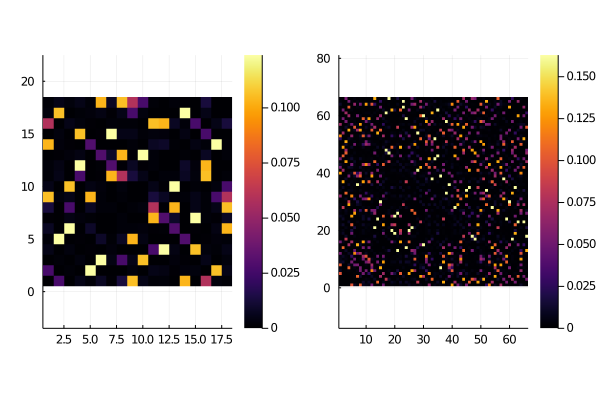

In [220]:
#
# Using these orbitals, let's semi-algorithmically cluster the system. 
# We'll start by separately looking at the π and σ spaces
# Using these orbital orderings, we can inspect to see how local the exchange matrix is
h,j,k = FermiCG.pyscf_get_jk(mol, C[:,1:tot_na] * C[:,1:tot_na]');

k1 = Cact'*(k)*Cact
k2 = Csig'*(k)*Csig
k1 = k1 - Diagonal(diag(k1))
k2 = k2 - Diagonal(diag(k2))
p1 = heatmap(abs.(k1), aspect_ratio=:equal)
p2 = heatmap(abs.(k2), aspect_ratio=:equal)
plot(p1, p2, layout = @layout [a  b])

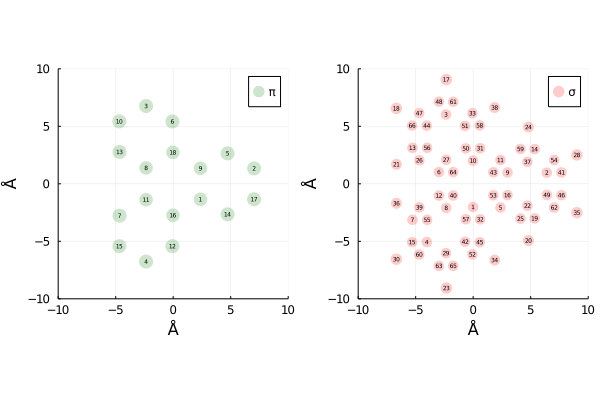

In [223]:
# 
# We can also inspect the orbital positions by looking at <r> and <r⋅r>
pymol = FermiCG.make_pyscf_mole(mol);
r1 = pymol.intor_symmetric("int1e_r");
r2 = pymol.intor_symmetric("int1e_r2");
rx_act = Cact'*r1[1,:,:]*Cact;
ry_act = Cact'*r1[2,:,:]*Cact;
rz_act = Cact'*r1[3,:,:]*Cact;
rx_sig = Csig'*r1[1,:,:]*Csig;
ry_sig = Csig'*r1[2,:,:]*Csig;
rz_sig = Csig'*r1[3,:,:]*Csig;
r2_act = Cact'*r2*Cact;
r2_sig = Csig'*r2*Csig;

var_act = diag(r2_act) - diag(rx_act).*diag(rx_act)- diag(ry_act).*diag(ry_act)- diag(rz_act).*diag(rz_act)
var_sig = diag(r2_sig) - diag(rx_sig).*diag(rx_sig)- diag(ry_sig).*diag(ry_sig)- diag(rz_sig).*diag(rz_sig)


p1 = scatter(diag(rx_act), diag(ry_act), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_act), 
    labels="π",xlims=(-10,10),ylims=(-10,10),  legendfont = font(8),    
    markeralpha = 0.2,
    markercolor = :green,
    markerstrokewidth = 0,
)

[annotate!(rx_act[i,i],ry_act[i,i],i, font(4)) for i in 1:size(rx_act,1)]

p2 = scatter(diag(rx_sig), diag(ry_sig), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_sig), 
    labels="σ",xlims=(-10,10),ylims=(-10,10),     
    markeralpha = 0.2,
    markercolor = :red,
    markerstrokewidth = 0,
)
[annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

# p3 = scatter([diag(rx_act), diag(rx_sig)], [diag(ry_act), diag(ry_sig)], aspect_ratio=:equal, 
#     markersize=5*sqrt.([var_act..., var_sig...]), 
#     labels="σ",xlims=(-10,10),ylims=(-10,10),     
#     markeralpha = 0.2,
#     markercolor = :red,
#     markerstrokewidth = 0,
# )
# [annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

plot(p1, p2, layout = @layout [a  b]
)
xlabel!("Å")
ylabel!("Å")

# 
# x and y axes are in units of Å. Each point corresponds to the mean position of the orbital, and the marker size 
# is 2*log(<r⋅r>). Thus, larger dots are more diffuse.

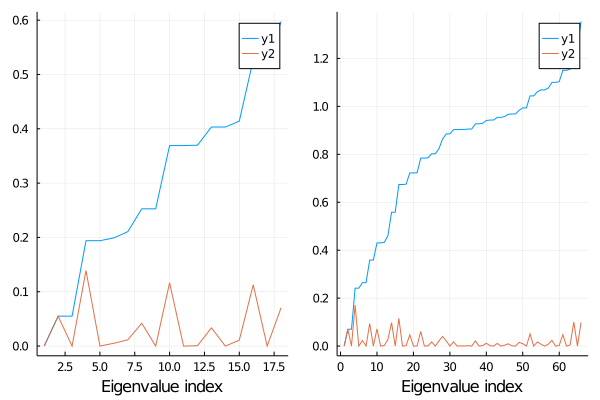

In [227]:
#
# From here, we could manually cluster. But we can instead try to use a k-means approach to spectral clustering. 
using Clustering
# h,j,k = FermiCG.pyscf_get_jk(mol, C[:,1:tot_na] * C[:,1:tot_na]');


k1 = Cact'*(k)*Cact;
k2 = Csig'*(k)*Csig;

nvecs = 3
A = abs.(k1)
L = Diagonal([sum(A[i,:]) for i in 1:size(A,1)]) - A;
F = eigen(L);
p1 = plot(F.values, xlabel="Eigenvalue")
p1 = plot!( [0,[F.values[i+1]-F.values[i] for i in 1:length(F.values)-1]...], xlabel="Eigenvalue index")

A_act = F.vectors[:,1:nvecs]*F.vectors[:,1:nvecs]'
clustering_act = clusterize(KMeansClusterizer(nvecs), A_act).assignments;
perm_act = sortperm(clustering_act)
p2 = heatmap(A_act, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")
A_act = A_act[perm_act, perm_act]
p3 = heatmap(A_act, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

Cact_sorted = Cact[:,perm_act]

nvecs = 3
A = abs.(k2)
L = Diagonal([sum(A[i,:]) for i in 1:size(A,1)]) - A;
F = eigen(L);
p4 = plot( F.values, xlabel="Eigenvalue index")
p4 = plot!( [0,[F.values[i+1]-F.values[i] for i in 1:length(F.values)-1]...], xlabel="Eigenvalue index")
A_sig = F.vectors[:,1:nvecs]*F.vectors[:,1:nvecs]'
p5 = heatmap(A_sig, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

clustering_sig = clusterize(KMeansClusterizer(nvecs), A_sig).assignments;
perm_sig = sortperm(clustering_sig)
A_sig = A_sig[perm_sig, perm_sig]
p6 = heatmap(A_sig, aspect_ratio=:equal, xlabel="Orbital", ylabel= "Orbital")

Csig_sorted = Csig[:,perm_sig]


FermiCG.pyscf_write_molden(mol, Cact_sorted, filename="act_sorted.molden");
FermiCG.pyscf_write_molden(mol, Csig_sorted, filename="sig_sorted.molden");
plot(p1, p4,  layout = @layout [a  b] )

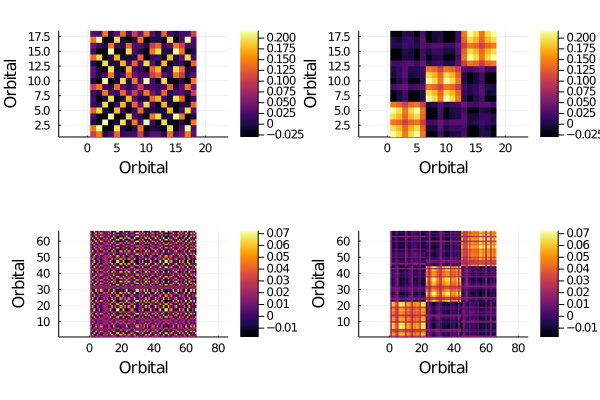

In [228]:
plot(p2, p3, p5, p6, layout = @layout [a  b ;c d])

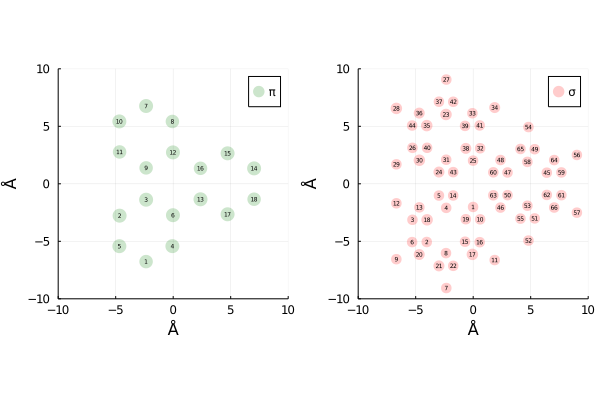

In [229]:
# 
# Now compare labelling
rx_act = Cact_sorted'*r1[1,:,:]*Cact_sorted;
ry_act = Cact_sorted'*r1[2,:,:]*Cact_sorted;
rx_sig = Csig_sorted'*r1[1,:,:]*Csig_sorted;
ry_sig = Csig_sorted'*r1[2,:,:]*Csig_sorted;
r2_act = Cact_sorted'*r2*Cact_sorted;
r2_sig = Csig_sorted'*r2*Csig_sorted;



p1 = scatter(diag(rx_act), diag(ry_act), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_act), 
    labels="π",xlims=(-10,10),ylims=(-10,10),  legendfont = font(8),    
    markeralpha = 0.2,
    markercolor = :green,
    markerstrokewidth = 0,
)



[annotate!(rx_act[i,i],ry_act[i,i],i, font(4)) for i in 1:size(rx_act,1)]

p2 = scatter(diag(rx_sig), diag(ry_sig), aspect_ratio=:equal, 
    markersize=5*sqrt.(var_sig), 
    labels="σ",xlims=(-10,10),ylims=(-10,10),     
    markeralpha = 0.2,
    markercolor = :red,
    markerstrokewidth = 0,
    lw = 1
)

[annotate!(rx_sig[i,i],ry_sig[i,i],i, font(4)) for i in 1:size(rx_sig,1)]

plot(p1, p2, layout = @layout [a  b]
)
xlabel!("Å")
ylabel!("Å")

# 
# x and y axes are in units of Å. Each point corresponds to the mean position of the orbital, and the marker size 
# is 2*log(<r⋅r>). Thus, larger dots are more diffuse.

In [302]:
#
# Build Integrals
ints = FermiCG.pyscf_build_ints(mol, Cact_sorted, 2.0*Cocc*Cocc');
@printf(" Ecore: %12.8f", ints.h0)

 Ecore: -647.52657385

In [310]:
#
# Define the clusters. These are tuples of orbital ranges.
clusters    = [(1:6), (7:12), (13:18)]

#
# Define the reference fock sectors. These are tuples of α, β electron counts.
# For the target clustering where we have 3 "benzene's", we'll have 6 electrons in each cluster.
init_fspace = [(3, 3),(3, 3),(3, 3)]

na = sum([i[1] for i in init_fspace]);
nb = sum([i[2] for i in init_fspace]);
ints.h0


-647.5265738468793

In [311]:
# define clusters
clusters = [Cluster(i,collect(clusters[i])) for i = 1:length(clusters)]
display(clusters)

rdm1 = zeros(size(ints.h1))

e_cmf, U, Da, Db  = FermiCG.cmf_oo(ints, clusters, init_fspace, rdm1,
                                        max_iter_oo=40, verbose=0, gconv=1e-6, method="bfgs");


3-element Array{Cluster,1}:
 Cluster(1, [1, 2, 3, 4, 5, 6])
 Cluster(2, [7, 8, 9, 10, 11, 12])
 Cluster(3, [13, 14, 15, 16, 17, 18])

 ooCMF Iter:    1 Total= -680.485734319727 Active= -32.959160472847 G=     5.31e-01
 ooCMF Iter:    2 Total= -680.565576412284 Active= -33.039002565405 G=     1.54e-01
 ooCMF Iter:    3 Total= -680.571211810736 Active= -33.044637963857 G=     4.29e-02
 ooCMF Iter:    4 Total= -680.571713287756 Active= -33.045139440876 G=     2.00e-02
 ooCMF Iter:    5 Total= -680.571884679851 Active= -33.045310832972 G=     1.60e-02
 ooCMF Iter:    6 Total= -680.572036088024 Active= -33.045462241145 G=     9.76e-03
 ooCMF Iter:    7 Total= -680.572060024596 Active= -33.045486177716 G=     2.13e-03
 ooCMF Iter:    8 Total= -680.572061321181 Active= -33.045487474301 G=     1.06e-03
 ooCMF Iter:    9 Total= -680.572061948092 Active= -33.045488101213 G=     6.85e-04
 ooCMF Iter:   10 Total= -680.572062183876 Active= -33.045488336997 G=     4.92e-04
 ooCMF Iter:   11 Total= -680.572062258363 Active= -33.045488411484 G=     9.78e-05
 ooCMF Iter:   12 Total= -680.572062265949 Active= -33.045488419070 G=     5

 * Status: success

 * Candidate solution
    Final objective value:     -6.805721e+02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 2.01e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.83e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.06e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.02e-14 ≰ 0.0e+00
    |g(x)|                 = 1.00e-06 ≤ 1.0e-06

 * Work counters
    Seconds run:   55  (vs limit Inf)
    Iterations:    15
    f(x) calls:    36
    ∇f(x) calls:   36


 ooCMF Iter:   16 Total= -680.572062267132 Active= -33.045488420253 G=     3.87e-06
*ooCMF -680.57206227 


(-680.5720622671323, [0.9987162965406683 0.0012399799352140026 … -0.012141237498727638 -4.2226852712523996e-5; 0.0013068941631438826 0.99721887747764 … -0.017095978218070684 0.0003127380635127262; … ; 0.01241640714983925 0.01672978789410054 … 0.9972186135943168 4.597936582701244e-5; -4.2265636271441224e-5 -0.00022479987266588546 … 4.856553176332118e-5 0.9987161889528479], [0.9996291125166048 -0.0008199360702789962 … 0.0 0.0; -0.0008199360702789962 1.0032195234165022 … 0.0 0.0; … ; 0.0 0.0 … 1.0032194888897985 0.6394487448906975; 0.0 0.0 … 0.6394487448906975 0.9996282291308588], [0.9996291125166048 -0.0008199360702789962 … 0.0 0.0; -0.0008199360702789962 1.0032195234165022 … 0.0 0.0; … ; 0.0 0.0 … 1.0032194888897985 0.6394487448906975; 0.0 0.0 … 0.6394487448906975 0.9996282291308588])

In [312]:
# Save molden file and rotate integrals
FermiCG.pyscf_write_molden(mol,Cact_sorted*U,filename="cmf.molden");
ints = FermiCG.orbital_rotation(ints,U);

In [338]:

max_roots = 100

#
# Build Cluster basis
cluster_bases = FermiCG.compute_cluster_eigenbasis(ints, clusters, verbose=1, max_roots=max_roots,
        init_fspace=init_fspace, rdm1a=Da, rdm1b=Db);

IDX001:DIM4096:001|002|003|004|005|006|
 Number of embedded electrons a,b: 12.000000 12.000000 FCIProblem:: #Orbs = 6   #α = 0  #β = 0  Dimension: 1        
   State    1 Energy:   0.00000000 -647.52657385
 FCIProblem:: #Orbs = 6   #α = 0  #β = 1  Dimension: 6        
   State    1 Energy:  -1.84463625 -649.37121009
   State    2 Energy:  -1.71865107 -649.24522492
   State    3 Energy:  -1.70603805 -649.23261189
   State    4 Energy:  -1.45483842 -648.98141227
   State    5 Energy:  -1.43363124 -648.96020508
   State    6 Energy:  -1.27356499 -648.80013884
 FCIProblem:: #Orbs = 6   #α = 0  #β = 2  Dimension: 15       
   State    1 Energy:  -3.34956333 -650.87613718
   State    2 Energy:  -3.33952429 -650.86609814
   State    3 Energy:  -3.17069965 -650.69727350
   State    4 Energy:  -3.04504502 -650.57161886
   State    5 Energy:  -3.02528403 -650.55185787
   State    6 Energy:  -2.96804892 -650.49462277
   State    7 Energy:  -2.95216023 -650.47873408
   State    8 Energy:  -2.88173

   State    1 Energy:  -5.52632794 -653.05290178
   State    2 Energy:  -5.42170348 -652.94827732
   State    3 Energy:  -5.42122506 -652.94779891
   State    4 Energy:  -5.27891336 -652.80548721
   State    5 Energy:  -5.27368872 -652.80026257
   State    6 Energy:  -5.27309664 -652.79967048
   State    7 Energy:  -5.25776483 -652.78433868
   State    8 Energy:  -5.19849098 -652.72506483
   State    9 Energy:  -5.19300513 -652.71957898
   State   10 Energy:  -5.17755221 -652.70412606
   State   11 Energy:  -5.17209024 -652.69866409
   State   12 Energy:  -5.11174948 -652.63832333
   State   13 Energy:  -5.10822345 -652.63479729
   State   14 Energy:  -5.10660399 -652.63317783
   State   15 Energy:  -5.08532868 -652.61190253
   State   16 Energy:  -5.08353086 -652.61010471
   State   17 Energy:  -5.07440136 -652.60097520
   State   18 Energy:  -5.04127485 -652.56784869
   State   19 Energy:  -5.04122314 -652.56779699
   State   20 Energy:  -5.01748955 -652.54406340
   State   21 Energy

   State   82 Energy:  -4.55855543 -652.08512927
   State   83 Energy:  -4.55117643 -652.07775028
   State   84 Energy:  -4.52043926 -652.04701310
   State   85 Energy:  -4.50473206 -652.03130591
   State   86 Energy:  -4.40153142 -651.92810527
   State   87 Energy:  -4.39461089 -651.92118474
   State   88 Energy:  -4.29557384 -651.82214769
   State   89 Energy:  -4.27549246 -651.80206631
   State   90 Energy:  -4.27025583 -651.79682968
 FCIProblem:: #Orbs = 6   #α = 1  #β = 5  Dimension: 36       
   State    1 Energy:  -6.02161117 -653.54818501
   State    2 Energy:  -5.94821194 -653.47478579
   State    3 Energy:  -5.94184932 -653.46842316
   State    4 Energy:  -5.80100484 -653.32757869
   State    5 Energy:  -5.79949403 -653.32606788
   State    6 Energy:  -5.70148278 -653.22805663
   State    7 Energy:  -5.68144439 -653.20801824
   State    8 Energy:  -5.67203174 -653.19860559
   State    9 Energy:  -5.62919776 -653.15577161
   State   10 Energy:  -5.57367234 -653.10024619
   Sta

   State   25 Energy:  -5.10660399 -652.63317783
   State   26 Energy:  -5.08532868 -652.61190253
   State   27 Energy:  -5.08353086 -652.61010471
   State   28 Energy:  -5.07440136 -652.60097520
   State   29 Energy:  -5.04127485 -652.56784869
   State   30 Energy:  -5.04122314 -652.56779699
   State   31 Energy:  -5.01748955 -652.54406340
   State   32 Energy:  -5.01572799 -652.54230184
   State   33 Energy:  -5.01371741 -652.54029126
   State   34 Energy:  -5.01144324 -652.53801709
   State   35 Energy:  -5.00873512 -652.53530896
   State   36 Energy:  -5.00791966 -652.53449350
   State   37 Energy:  -4.99985741 -652.52643125
   State   38 Energy:  -4.99341438 -652.51998823
   State   39 Energy:  -4.97560363 -652.50217747
   State   40 Energy:  -4.96915714 -652.49573098
   State   41 Energy:  -4.96171273 -652.48828658
   State   42 Energy:  -4.94973086 -652.47630471
   State   43 Energy:  -4.94970908 -652.47628292
   State   44 Energy:  -4.94603267 -652.47260652
   State   45 Energy

   State   89 Energy:  -5.28688930 -652.81346315
   State   90 Energy:  -5.25574779 -652.78232163
   State   91 Energy:  -5.25538318 -652.78195703
   State   92 Energy:  -5.23984972 -652.76642357
   State   93 Energy:  -5.23850925 -652.76508310
   State   94 Energy:  -5.23826028 -652.76483412
   State   95 Energy:  -5.23037664 -652.75695049
   State   96 Energy:  -5.22254319 -652.74911703
   State   97 Energy:  -5.21800345 -652.74457729
   State   98 Energy:  -5.21294562 -652.73951947
   State   99 Energy:  -5.21170502 -652.73827887
   State  100 Energy:  -5.20942697 -652.73600082
 FCIProblem:: #Orbs = 6   #α = 2  #β = 5  Dimension: 90       
   State    1 Energy:  -5.90699776 -653.43357160
   State    2 Energy:  -5.89702523 -653.42359907
   State    3 Energy:  -5.81957318 -653.34614702
   State    4 Energy:  -5.76907105 -653.29564490
   State    5 Energy:  -5.76341630 -653.28999015
   State    6 Energy:  -5.75625142 -653.28282526
   State    7 Energy:  -5.63571229 -653.16228614
   Sta

   State    1 Energy:  -6.09706799 -653.62364184
   State    2 Energy:  -6.09444359 -653.62101744
   State    3 Energy:  -5.98224307 -653.50881691
   State    4 Energy:  -5.90760014 -653.43417398
   State    5 Energy:  -5.89773889 -653.42431273
   State    6 Energy:  -5.87144285 -653.39801670
   State    7 Energy:  -5.87113447 -653.39770831
   State    8 Energy:  -5.82574606 -653.35231991
   State    9 Energy:  -5.82217155 -653.34874540
   State   10 Energy:  -5.81538677 -653.34196062
   State   11 Energy:  -5.80981494 -653.33638879
   State   12 Energy:  -5.80004107 -653.32661491
   State   13 Energy:  -5.79622444 -653.32279829
   State   14 Energy:  -5.77519313 -653.30176698
   State   15 Energy:  -5.76149166 -653.28806550
   State   16 Energy:  -5.74722141 -653.27379526
   State   17 Energy:  -5.74100172 -653.26757556
   State   18 Energy:  -5.71280362 -653.23937747
   State   19 Energy:  -5.70961359 -653.23618744
   State   20 Energy:  -5.67781269 -653.20438654
   State   21 Energy

   State   16 Energy:  -5.73660176 -653.26317561
   State   17 Energy:  -5.72289852 -653.24947237
   State   18 Energy:  -5.72148980 -653.24806365
   State   19 Energy:  -5.72020637 -653.24678022
   State   20 Energy:  -5.63972889 -653.16630274
   State   21 Energy:  -5.63571229 -653.16228614
   State   22 Energy:  -5.63463629 -653.16121014
   State   23 Energy:  -5.63102765 -653.15760149
   State   24 Energy:  -5.61562449 -653.14219834
   State   25 Energy:  -5.61279787 -653.13937171
   State   26 Energy:  -5.60662940 -653.13320324
   State   27 Energy:  -5.58012011 -653.10669396
   State   28 Energy:  -5.57599108 -653.10256492
   State   29 Energy:  -5.57007122 -653.09664506
   State   30 Energy:  -5.56951212 -653.09608596
   State   31 Energy:  -5.54403804 -653.07061189
   State   32 Energy:  -5.53547997 -653.06205382
   State   33 Energy:  -5.53309589 -653.05966974
   State   34 Energy:  -5.52914380 -653.05571765
   State   35 Energy:  -5.50370088 -653.03027472
   State   36 Energy

   State   83 Energy:  -4.29314400 -651.81971785
   State   84 Energy:  -4.27500252 -651.80157636
   State   85 Energy:  -4.24082358 -651.76739743
   State   86 Energy:  -4.22835711 -651.75493095
   State   87 Energy:  -4.21132416 -651.73789800
   State   88 Energy:  -4.20962685 -651.73620069
   State   89 Energy:  -4.20274045 -651.72931429
   State   90 Energy:  -4.20148199 -651.72805584
   State   91 Energy:  -4.18323162 -651.70980546
   State   92 Energy:  -4.16790378 -651.69447763
   State   93 Energy:  -4.16379788 -651.69037173
   State   94 Energy:  -4.14108741 -651.66766125
   State   95 Energy:  -4.13432683 -651.66090067
   State   96 Energy:  -4.12628202 -651.65285587
   State   97 Energy:  -4.08024546 -651.60681931
   State   98 Energy:  -4.07724186 -651.60381571
   State   99 Energy:  -4.06444208 -651.59101593
   State  100 Energy:  -4.05748541 -651.58405926
 FCIProblem:: #Orbs = 6   #α = 3  #β = 6  Dimension: 20       
   State    1 Energy:  -4.53409703 -652.06067088
   Sta

   State   81 Energy:  -5.30494463 -652.83151847
   State   82 Energy:  -5.29774545 -652.82431929
   State   83 Energy:  -5.29677387 -652.82334772
   State   84 Energy:  -5.29405672 -652.82063057
   State   85 Energy:  -5.29386298 -652.82043682
   State   86 Energy:  -5.29298874 -652.81956259
   State   87 Energy:  -5.29056712 -652.81714097
   State   88 Energy:  -5.28925218 -652.81582602
   State   89 Energy:  -5.28688930 -652.81346315
   State   90 Energy:  -5.25574779 -652.78232163
   State   91 Energy:  -5.25538318 -652.78195703
   State   92 Energy:  -5.23984972 -652.76642357
   State   93 Energy:  -5.23850925 -652.76508310
   State   94 Energy:  -5.23826028 -652.76483412
   State   95 Energy:  -5.23037664 -652.75695049
   State   96 Energy:  -5.22254319 -652.74911703
   State   97 Energy:  -5.21800345 -652.74457729
   State   98 Energy:  -5.21294562 -652.73951947
   State   99 Energy:  -5.21170502 -652.73827887
   State  100 Energy:  -5.20942697 -652.73600082
 FCIProblem:: #Orbs 

   State    1 Energy:  -4.61242140 -652.13899524
   State    2 Energy:  -4.61066964 -652.13724348
   State    3 Energy:  -4.53409703 -652.06067088
   State    4 Energy:  -4.45492097 -651.98149482
   State    5 Energy:  -4.45109908 -651.97767292
   State    6 Energy:  -4.35095748 -651.87753132
   State    7 Energy:  -4.27940514 -651.80597899
   State    8 Energy:  -4.26307161 -651.78964545
   State    9 Energy:  -4.25955361 -651.78612746
   State   10 Energy:  -4.24864266 -651.77521650
   State   11 Energy:  -4.22359872 -651.75017257
   State   12 Energy:  -4.21906080 -651.74563465
   State   13 Energy:  -4.21805503 -651.74462888
   State   14 Energy:  -4.19639365 -651.72296750
   State   15 Energy:  -4.18100204 -651.70757588
   State   16 Energy:  -4.17991457 -651.70648842
   State   17 Energy:  -4.13922302 -651.66579687
   State   18 Energy:  -4.07064573 -651.59721958
   State   19 Energy:  -4.06982278 -651.59639663
   State   20 Energy:  -4.06563159 -651.59220543
   State   21 Energy

   State   95 Energy:  -4.13432683 -651.66090067
   State   96 Energy:  -4.12628202 -651.65285587
   State   97 Energy:  -4.08024546 -651.60681931
   State   98 Energy:  -4.07724186 -651.60381571
   State   99 Energy:  -4.06444208 -651.59101593
   State  100 Energy:  -4.05748541 -651.58405926
 FCIProblem:: #Orbs = 6   #α = 5  #β = 4  Dimension: 90       
   State    1 Energy:  -4.61242140 -652.13899524
   State    2 Energy:  -4.61066964 -652.13724348
   State    3 Energy:  -4.53409703 -652.06067088
   State    4 Energy:  -4.45492097 -651.98149482
   State    5 Energy:  -4.45109908 -651.97767292
   State    6 Energy:  -4.35095748 -651.87753132
   State    7 Energy:  -4.27940514 -651.80597899
   State    8 Energy:  -4.26307161 -651.78964545
   State    9 Energy:  -4.25955361 -651.78612746
   State   10 Energy:  -4.24864266 -651.77521650
   State   11 Energy:  -4.22359872 -651.75017257
   State   12 Energy:  -4.21906080 -651.74563465
   State   13 Energy:  -4.21805503 -651.74462888
   Sta

   State    1 Energy:  -3.28176300 -650.80833685
   State    2 Energy:  -3.27672596 -650.80329980
   State    3 Energy:  -3.03293977 -650.55951362
   State    4 Energy:  -2.94680277 -650.47337662
   State    5 Energy:  -2.92847387 -650.45504772
   State    6 Energy:  -2.84682275 -650.37339660
   State    7 Energy:  -2.79381657 -650.32039042
   State    8 Energy:  -2.72615558 -650.25272943
   State    9 Energy:  -2.72101437 -650.24758822
   State   10 Energy:  -2.70402650 -650.23060035
   State   11 Energy:  -2.59464510 -650.12121895
   State   12 Energy:  -2.58764883 -650.11422268
   State   13 Energy:  -2.43245703 -649.95903087
   State   14 Energy:  -2.35317601 -649.87974986
   State   15 Energy:  -2.33648103 -649.86305487
 FCIProblem:: #Orbs = 6   #α = 6  #β = 5  Dimension: 6        
   State    1 Energy:  -1.75165970 -649.27823354
   State    2 Energy:  -1.55858264 -649.08515649
   State    3 Energy:  -1.55075960 -649.07733345
   State    4 Energy:  -1.26691390 -648.79348774
   Sta

   State   85 Energy:  -4.32452886 -651.85110271
   State   86 Energy:  -4.31193961 -651.83851346
   State   87 Energy:  -4.28892563 -651.81549948
   State   88 Energy:  -4.28548308 -651.81205693
   State   89 Energy:  -4.28153131 -651.80810516
   State   90 Energy:  -4.27740055 -651.80397439
   State   91 Energy:  -4.26441747 -651.79099132
   State   92 Energy:  -4.21414093 -651.74071478
   State   93 Energy:  -4.20832996 -651.73490381
   State   94 Energy:  -4.19793922 -651.72451306
   State   95 Energy:  -4.18473828 -651.71131212
   State   96 Energy:  -4.17713542 -651.70370927
   State   97 Energy:  -4.15539405 -651.68196789
   State   98 Energy:  -4.15233958 -651.67891343
   State   99 Energy:  -4.13606673 -651.66264057
   State  100 Energy:  -4.13568889 -651.66226274
 FCIProblem:: #Orbs = 6   #α = 1  #β = 4  Dimension: 90       
   State    1 Energy:  -5.90760014 -653.43417398
   State    2 Energy:  -5.89773889 -653.42431273
   State    3 Energy:  -5.81538677 -653.34196062
   Sta

   State    1 Energy:  -5.52632794 -653.05290178
   State    2 Energy:  -5.49447589 -653.02104974
   State    3 Energy:  -5.49159961 -653.01817346
   State    4 Energy:  -5.47171344 -652.99828728
   State    5 Energy:  -5.42170348 -652.94827732
   State    6 Energy:  -5.42122506 -652.94779891
   State    7 Energy:  -5.27891336 -652.80548721
   State    8 Energy:  -5.27368872 -652.80026257
   State    9 Energy:  -5.27309664 -652.79967048
   State   10 Energy:  -5.26579520 -652.79236905
   State   11 Energy:  -5.26411047 -652.79068431
   State   12 Energy:  -5.25776483 -652.78433868
   State   13 Energy:  -5.20073776 -652.72731161
   State   14 Energy:  -5.19849098 -652.72506483
   State   15 Energy:  -5.19333256 -652.71990641
   State   16 Energy:  -5.19300513 -652.71957898
   State   17 Energy:  -5.17755221 -652.70412606
   State   18 Energy:  -5.17209024 -652.69866409
   State   19 Energy:  -5.15151758 -652.67809143
   State   20 Energy:  -5.14150372 -652.66807757
   State   21 Energy

   State   48 Energy:  -5.49718220 -653.02375605
   State   49 Energy:  -5.48865404 -653.01522788
   State   50 Energy:  -5.48728418 -653.01385803
   State   51 Energy:  -5.48536966 -653.01194350
   State   52 Energy:  -5.47566064 -653.00223448
   State   53 Energy:  -5.47054965 -652.99712350
   State   54 Energy:  -5.46238216 -652.98895601
   State   55 Energy:  -5.46206562 -652.98863946
   State   56 Energy:  -5.45199203 -652.97856588
   State   57 Energy:  -5.45159551 -652.97816935
   State   58 Energy:  -5.44403469 -652.97060854
   State   59 Energy:  -5.44245601 -652.96902985
   State   60 Energy:  -5.43923115 -652.96580500
   State   61 Energy:  -5.43650090 -652.96307475
   State   62 Energy:  -5.43267264 -652.95924649
   State   63 Energy:  -5.41986737 -652.94644121
   State   64 Energy:  -5.40077222 -652.92734607
   State   65 Energy:  -5.39171103 -652.91828488
   State   66 Energy:  -5.39034753 -652.91692137
   State   67 Energy:  -5.38501538 -652.91158923
   State   68 Energy

   State   46 Energy:  -4.72917857 -652.25575241
   State   47 Energy:  -4.71955179 -652.24612563
   State   48 Energy:  -4.71644067 -652.24301452
   State   49 Energy:  -4.70860985 -652.23518370
   State   50 Energy:  -4.70374384 -652.23031769
   State   51 Energy:  -4.70051629 -652.22709014
   State   52 Energy:  -4.69878129 -652.22535513
   State   53 Energy:  -4.69791472 -652.22448857
   State   54 Energy:  -4.64753043 -652.17410428
   State   55 Energy:  -4.63090229 -652.15747614
   State   56 Energy:  -4.61886630 -652.14544014
   State   57 Energy:  -4.61706592 -652.14363977
   State   58 Energy:  -4.61614747 -652.14272132
   State   59 Energy:  -4.61356461 -652.14013846
   State   60 Energy:  -4.59142582 -652.11799967
   State   61 Energy:  -4.55884364 -652.08541749
   State   62 Energy:  -4.55769564 -652.08426948
   State   63 Energy:  -4.55438563 -652.08095947
   State   64 Energy:  -4.55148964 -652.07806349
   State   65 Energy:  -4.54382464 -652.07039848
   State   66 Energy

   State   17 Energy:  -5.94184932 -653.46842316
   State   18 Energy:  -5.91215602 -653.43872987
   State   19 Energy:  -5.87634768 -653.40292153
   State   20 Energy:  -5.86187496 -653.38844880
   State   21 Energy:  -5.86139027 -653.38796411
   State   22 Energy:  -5.85780796 -653.38438180
   State   23 Energy:  -5.85596548 -653.38253933
   State   24 Energy:  -5.85461576 -653.38118960
   State   25 Energy:  -5.82202155 -653.34859540
   State   26 Energy:  -5.81797956 -653.34455341
   State   27 Energy:  -5.80100484 -653.32757869
   State   28 Energy:  -5.79949403 -653.32606788
   State   29 Energy:  -5.79626093 -653.32283477
   State   30 Energy:  -5.79179302 -653.31836687
   State   31 Energy:  -5.79095365 -653.31752749
   State   32 Energy:  -5.75697338 -653.28354723
   State   33 Energy:  -5.74890952 -653.27548337
   State   34 Energy:  -5.74595365 -653.27252750
   State   35 Energy:  -5.74426766 -653.27084150
   State   36 Energy:  -5.73042137 -653.25699522
   State   37 Energy

   State    1 Energy:  -4.53409703 -652.06067088
   State    2 Energy:  -4.26307161 -651.78964545
   State    3 Energy:  -4.22359872 -651.75017257
   State    4 Energy:  -4.18100204 -651.70757588
   State    5 Energy:  -4.17991457 -651.70648842
   State    6 Energy:  -4.07064573 -651.59721958
   State    7 Energy:  -4.06982278 -651.59639663
   State    8 Energy:  -3.96756859 -651.49414244
   State    9 Energy:  -3.95443056 -651.48100440
   State   10 Energy:  -3.86436202 -651.39093586
   State   11 Energy:  -3.80030462 -651.32687847
   State   12 Energy:  -3.77579730 -651.30237114
   State   13 Energy:  -3.76489973 -651.29147357
   State   14 Energy:  -3.65104366 -651.17761751
   State   15 Energy:  -3.64872152 -651.17529536
   State   16 Energy:  -3.60126167 -651.12783551
   State   17 Energy:  -3.59338542 -651.11995927
   State   18 Energy:  -3.53938042 -651.06595427
   State   19 Energy:  -3.53809417 -651.06466802
   State   20 Energy:  -3.30871539 -650.83528923
 FCIProblem:: #Orbs 

   State    1 Energy:  -6.10435779 -653.63093164
   State    2 Energy:  -6.10168458 -653.62825843
   State    3 Energy:  -5.95420289 -653.48077673
   State    4 Energy:  -5.90699776 -653.43357160
   State    5 Energy:  -5.89702523 -653.42359907
   State    6 Energy:  -5.87060540 -653.39717924
   State    7 Energy:  -5.87057365 -653.39714750
   State    8 Energy:  -5.81957318 -653.34614702
   State    9 Energy:  -5.81926281 -653.34583666
   State   10 Energy:  -5.81595380 -653.34252764
   State   11 Energy:  -5.77295580 -653.29952965
   State   12 Energy:  -5.76907105 -653.29564490
   State   13 Energy:  -5.76341630 -653.28999015
   State   14 Energy:  -5.75625142 -653.28282526
   State   15 Energy:  -5.74229742 -653.26887126
   State   16 Energy:  -5.73660176 -653.26317561
   State   17 Energy:  -5.72289852 -653.24947237
   State   18 Energy:  -5.72148980 -653.24806365
   State   19 Energy:  -5.72020637 -653.24678022
   State   20 Energy:  -5.63972889 -653.16630274
   State   21 Energy

   State    1 Energy:  -4.61242140 -652.13899524
   State    2 Energy:  -4.61066964 -652.13724348
   State    3 Energy:  -4.53409703 -652.06067088
   State    4 Energy:  -4.45492097 -651.98149482
   State    5 Energy:  -4.45109908 -651.97767292
   State    6 Energy:  -4.35095748 -651.87753132
   State    7 Energy:  -4.27940514 -651.80597899
   State    8 Energy:  -4.26307161 -651.78964545
   State    9 Energy:  -4.25955361 -651.78612746
   State   10 Energy:  -4.24864266 -651.77521650
   State   11 Energy:  -4.22359872 -651.75017257
   State   12 Energy:  -4.21906080 -651.74563465
   State   13 Energy:  -4.21805503 -651.74462888
   State   14 Energy:  -4.19639365 -651.72296750
   State   15 Energy:  -4.18100204 -651.70757588
   State   16 Energy:  -4.17991457 -651.70648842
   State   17 Energy:  -4.13922302 -651.66579687
   State   18 Energy:  -4.07064573 -651.59721958
   State   19 Energy:  -4.06982278 -651.59639663
   State   20 Energy:  -4.06563159 -651.59220543
   State   21 Energy

   State   93 Energy:  -4.16379788 -651.69037173
   State   94 Energy:  -4.14108741 -651.66766125
   State   95 Energy:  -4.13432683 -651.66090067
   State   96 Energy:  -4.12628202 -651.65285587
   State   97 Energy:  -4.08024546 -651.60681931
   State   98 Energy:  -4.07724186 -651.60381571
   State   99 Energy:  -4.06444208 -651.59101593
   State  100 Energy:  -4.05748541 -651.58405926
 FCIProblem:: #Orbs = 6   #α = 5  #β = 4  Dimension: 90       
   State    1 Energy:  -4.61242140 -652.13899524
   State    2 Energy:  -4.61066964 -652.13724348
   State    3 Energy:  -4.53409703 -652.06067088
   State    4 Energy:  -4.45492097 -651.98149482
   State    5 Energy:  -4.45109908 -651.97767292
   State    6 Energy:  -4.35095748 -651.87753132
   State    7 Energy:  -4.27940514 -651.80597899
   State    8 Energy:  -4.26307161 -651.78964545
   State    9 Energy:  -4.25955361 -651.78612746
   State   10 Energy:  -4.24864266 -651.77521650
   State   11 Energy:  -4.22359872 -651.75017257
   Sta

   State    1 Energy:  -3.34957107 -650.87614492
   State    2 Energy:  -3.33952546 -650.86609931
   State    3 Energy:  -3.17070329 -650.69727714
   State    4 Energy:  -3.04504631 -650.57162015
   State    5 Energy:  -3.02528894 -650.55186279
   State    6 Energy:  -2.96805183 -650.49462568
   State    7 Energy:  -2.95216191 -650.47873576
   State    8 Energy:  -2.88174084 -650.40831469
   State    9 Energy:  -2.88140767 -650.40798152
   State   10 Energy:  -2.80365773 -650.33023158
   State   11 Energy:  -2.71287647 -650.23945031
   State   12 Energy:  -2.69996778 -650.22654163
   State   13 Energy:  -2.61338645 -650.13996030
   State   14 Energy:  -2.49983677 -650.02641062
   State   15 Energy:  -2.48373782 -650.01031166
 FCIProblem:: #Orbs = 6   #α = 0  #β = 3  Dimension: 20       
   State    1 Energy:  -4.58062020 -652.10719405
   State    2 Energy:  -4.33315140 -651.85972525
   State    3 Energy:  -4.29454908 -651.82112293
   State    4 Energy:  -4.25159842 -651.77817227
   Sta

   State    1 Energy:  -5.52633547 -653.05290931
   State    2 Energy:  -5.42170875 -652.94828260
   State    3 Energy:  -5.42123354 -652.94780739
   State    4 Energy:  -5.27891938 -652.80549323
   State    5 Energy:  -5.27369180 -652.80026565
   State    6 Energy:  -5.27310265 -652.79967650
   State    7 Energy:  -5.25777350 -652.78434735
   State    8 Energy:  -5.19849657 -652.72507042
   State    9 Energy:  -5.19301096 -652.71958481
   State   10 Energy:  -5.17755662 -652.70413047
   State   11 Energy:  -5.17209812 -652.69867196
   State   12 Energy:  -5.11175397 -652.63832782
   State   13 Energy:  -5.10822885 -652.63480270
   State   14 Energy:  -5.10661071 -652.63318456
   State   15 Energy:  -5.08533661 -652.61191046
   State   16 Energy:  -5.08353193 -652.61010578
   State   17 Energy:  -5.07440974 -652.60098358
   State   18 Energy:  -5.04128021 -652.56785406
   State   19 Energy:  -5.04122819 -652.56780204
   State   20 Energy:  -5.01749394 -652.54406779
   State   21 Energy

   State   89 Energy:  -4.27549415 -651.80206800
   State   90 Energy:  -4.27025788 -651.79683173
 FCIProblem:: #Orbs = 6   #α = 1  #β = 5  Dimension: 36       
   State    1 Energy:  -6.02161734 -653.54819118
   State    2 Energy:  -5.94821540 -653.47478925
   State    3 Energy:  -5.94185813 -653.46843197
   State    4 Energy:  -5.80100891 -653.32758276
   State    5 Energy:  -5.79950034 -653.32607418
   State    6 Energy:  -5.70148703 -653.22806088
   State    7 Energy:  -5.68144909 -653.20802294
   State    8 Energy:  -5.67203969 -653.19861353
   State    9 Energy:  -5.62920349 -653.15577734
   State   10 Energy:  -5.57367834 -653.10025218
   State   11 Energy:  -5.46238687 -652.98896072
   State   12 Energy:  -5.46207128 -652.98864513
   State   13 Energy:  -5.44403899 -652.97061284
   State   14 Energy:  -5.44246185 -652.96903569
   State   15 Energy:  -5.37208470 -652.89865855
   State   16 Energy:  -5.36609886 -652.89267271
   State   17 Energy:  -5.34536042 -652.87193426
   Sta

   State  100 Energy:  -4.59287336 -652.11944720
 FCIProblem:: #Orbs = 6   #α = 2  #β = 3  Dimension: 300      
   State    1 Energy:  -6.09707420 -653.62364805
   State    2 Energy:  -6.09445432 -653.62102817
   State    3 Energy:  -5.98225082 -653.50882466
   State    4 Energy:  -5.90760496 -653.43417880
   State    5 Energy:  -5.89774823 -653.42432208
   State    6 Energy:  -5.87145034 -653.39802418
   State    7 Energy:  -5.87113990 -653.39771375
   State    8 Energy:  -5.82575263 -653.35232648
   State    9 Energy:  -5.82217928 -653.34875313
   State   10 Energy:  -5.81539053 -653.34196438
   State   11 Energy:  -5.80982209 -653.33639594
   State   12 Energy:  -5.80004815 -653.32662199
   State   13 Energy:  -5.79623326 -653.32280711
   State   14 Energy:  -5.77520036 -653.30177420
   State   15 Energy:  -5.76149764 -653.28807149
   State   16 Energy:  -5.74722807 -653.27380192
   State   17 Energy:  -5.74100839 -653.26758224
   State   18 Energy:  -5.71280898 -653.23938283
   Sta

   State    1 Energy:  -5.90700300 -653.43357685
   State    2 Energy:  -5.89703460 -653.42360845
   State    3 Energy:  -5.81958044 -653.34615429
   State    4 Energy:  -5.76907361 -653.29564746
   State    5 Energy:  -5.76342360 -653.28999745
   State    6 Energy:  -5.75626102 -653.28283486
   State    7 Energy:  -5.63571769 -653.16229153
   State    8 Energy:  -5.63464248 -653.16121633
   State    9 Energy:  -5.63103305 -653.15760689
   State   10 Energy:  -5.57007794 -653.09665178
   State   11 Energy:  -5.56951670 -653.09609054
   State   12 Energy:  -5.54404382 -653.07061767
   State   13 Energy:  -5.53548570 -653.06205955
   State   14 Energy:  -5.50370795 -653.03028180
   State   15 Energy:  -5.50342295 -653.02999680
   State   16 Energy:  -5.49158485 -653.01815870
   State   17 Energy:  -5.48898190 -653.01555575
   State   18 Energy:  -5.48527086 -653.01184471
   State   19 Energy:  -5.42375623 -652.95033007
   State   20 Energy:  -5.36115351 -652.88772735
   State   21 Energy

   State   24 Energy:  -5.64130838 -653.16788222
   State   25 Energy:  -5.62869394 -653.15526779
   State   26 Energy:  -5.62561584 -653.15218969
   State   27 Energy:  -5.62185171 -653.14842556
   State   28 Energy:  -5.61963755 -653.14621140
   State   29 Energy:  -5.59021603 -653.11678988
   State   30 Energy:  -5.58867142 -653.11524527
   State   31 Energy:  -5.56970051 -653.09627436
   State   32 Energy:  -5.56505481 -653.09162866
   State   33 Energy:  -5.53441526 -653.06098911
   State   34 Energy:  -5.52987937 -653.05645322
   State   35 Energy:  -5.51527063 -653.04184447
   State   36 Energy:  -5.51428538 -653.04085923
   State   37 Energy:  -5.51410245 -653.04067630
   State   38 Energy:  -5.51351587 -653.04008972
   State   39 Energy:  -5.51159296 -653.03816681
   State   40 Energy:  -5.50882293 -653.03539678
   State   41 Energy:  -5.49967086 -653.02624471
   State   42 Energy:  -5.49910942 -653.02568327
   State   43 Energy:  -5.49604242 -653.02261627
   State   44 Energy

   State   17 Energy:  -5.72290396 -653.24947781
   State   18 Energy:  -5.72149844 -653.24807228
   State   19 Energy:  -5.72021367 -653.24678751
   State   20 Energy:  -5.63973613 -653.16630997
   State   21 Energy:  -5.63571769 -653.16229153
   State   22 Energy:  -5.63464248 -653.16121633
   State   23 Energy:  -5.63103305 -653.15760689
   State   24 Energy:  -5.61563067 -653.14220452
   State   25 Energy:  -5.61280696 -653.13938081
   State   26 Energy:  -5.60663452 -653.13320837
   State   27 Energy:  -5.58012589 -653.10669974
   State   28 Energy:  -5.57599949 -653.10257334
   State   29 Energy:  -5.57007794 -653.09665178
   State   30 Energy:  -5.56951670 -653.09609054
   State   31 Energy:  -5.54404382 -653.07061767
   State   32 Energy:  -5.53548570 -653.06205955
   State   33 Energy:  -5.53310045 -653.05967429
   State   34 Energy:  -5.52915183 -653.05572568
   State   35 Energy:  -5.50370795 -653.03028180
   State   36 Energy:  -5.50342295 -653.02999680
   State   37 Energy

   State   99 Energy:  -4.06444416 -651.59101801
   State  100 Energy:  -4.05748795 -651.58406180
 FCIProblem:: #Orbs = 6   #α = 3  #β = 6  Dimension: 20       
   State    1 Energy:  -4.53410325 -652.06067709
   State    2 Energy:  -4.26307562 -651.78964947
   State    3 Energy:  -4.22360408 -651.75017792
   State    4 Energy:  -4.18100789 -651.70758173
   State    5 Energy:  -4.17991897 -651.70649281
   State    6 Energy:  -4.07064802 -651.59722186
   State    7 Energy:  -4.06982979 -651.59640364
   State    8 Energy:  -3.96756946 -651.49414331
   State    9 Energy:  -3.95443755 -651.48101139
   State   10 Energy:  -3.86436529 -651.39093913
   State   11 Energy:  -3.80030807 -651.32688192
   State   12 Energy:  -3.77579828 -651.30237213
   State   13 Energy:  -3.76490532 -651.29147917
   State   14 Energy:  -3.65104518 -651.17761903
   State   15 Energy:  -3.64872559 -651.17529943
   State   16 Energy:  -3.60126439 -651.12783824
   State   17 Energy:  -3.59338702 -651.11996087
   Sta

   State   91 Energy:  -5.25538844 -652.78196228
   State   92 Energy:  -5.23985394 -652.76642779
   State   93 Energy:  -5.23851296 -652.76508680
   State   94 Energy:  -5.23826629 -652.76484013
   State   95 Energy:  -5.23038076 -652.75695461
   State   96 Energy:  -5.22254797 -652.74912181
   State   97 Energy:  -5.21800885 -652.74458269
   State   98 Energy:  -5.21295002 -652.73952386
   State   99 Energy:  -5.21170860 -652.73828245
   State  100 Energy:  -5.20943190 -652.73600575
 FCIProblem:: #Orbs = 6   #α = 4  #β = 3  Dimension: 300      
   State    1 Energy:  -6.10436399 -653.63093783
   State    2 Energy:  -6.10169585 -653.62826970
   State    3 Energy:  -5.95421054 -653.48078438
   State    4 Energy:  -5.90700300 -653.43357685
   State    5 Energy:  -5.89703460 -653.42360845
   State    6 Energy:  -5.87061090 -653.39718475
   State    7 Energy:  -5.87058160 -653.39715544
   State    8 Energy:  -5.81958044 -653.34615429
   State    9 Energy:  -5.81926973 -653.34584357
   Sta

   State    1 Energy:  -4.61243056 -652.13900441
   State    2 Energy:  -4.61067445 -652.13724830
   State    3 Energy:  -4.53410325 -652.06067709
   State    4 Energy:  -4.45492712 -651.98150096
   State    5 Energy:  -4.45110536 -651.97767921
   State    6 Energy:  -4.35096362 -651.87753747
   State    7 Energy:  -4.27941093 -651.80598477
   State    8 Energy:  -4.26307562 -651.78964947
   State    9 Energy:  -4.25955824 -651.78613209
   State   10 Energy:  -4.24864910 -651.77522294
   State   11 Energy:  -4.22360408 -651.75017792
   State   12 Energy:  -4.21906492 -651.74563877
   State   13 Energy:  -4.21806118 -651.74463502
   State   14 Energy:  -4.19639931 -651.72297316
   State   15 Energy:  -4.18100789 -651.70758173
   State   16 Energy:  -4.17991897 -651.70649281
   State   17 Energy:  -4.13922758 -651.66580143
   State   18 Energy:  -4.07064802 -651.59722186
   State   19 Energy:  -4.06982979 -651.59640364
   State   20 Energy:  -4.06563404 -651.59220789
   State   21 Energy

   State   14 Energy:  -5.06586963 -652.59244348
   State   15 Energy:  -5.03858906 -652.56516291
   State   16 Energy:  -5.02670744 -652.55328129
   State   17 Energy:  -5.02495921 -652.55153306
   State   18 Energy:  -5.01798510 -652.54455895
   State   19 Energy:  -4.98356937 -652.51014322
   State   20 Energy:  -4.97755330 -652.50412715
   State   21 Energy:  -4.97386123 -652.50043507
   State   22 Energy:  -4.93398650 -652.46056035
   State   23 Energy:  -4.92270953 -652.44928338
   State   24 Energy:  -4.88165874 -652.40823259
   State   25 Energy:  -4.88075979 -652.40733364
   State   26 Energy:  -4.85955612 -652.38612997
   State   27 Energy:  -4.85300380 -652.37957765
   State   28 Energy:  -4.85085523 -652.37742908
   State   29 Energy:  -4.84174208 -652.36831593
   State   30 Energy:  -4.83373680 -652.36031064
   State   31 Energy:  -4.82613750 -652.35271134
   State   32 Energy:  -4.80713981 -652.33371366
   State   33 Energy:  -4.79789459 -652.32446844
   State   34 Energy

   State    1 Energy:  -3.40634184 -650.93291569
   State    2 Energy:  -3.28177134 -650.80834519
   State    3 Energy:  -3.27672763 -650.80330147
   State    4 Energy:  -3.11204407 -650.63861792
   State    5 Energy:  -3.10824316 -650.63481701
   State    6 Energy:  -3.06574529 -650.59231913
   State    7 Energy:  -3.05963458 -650.58620843
   State    8 Energy:  -3.03294358 -650.55951743
   State    9 Energy:  -2.94680468 -650.47337853
   State   10 Energy:  -2.92847906 -650.45505291
   State   11 Energy:  -2.91360831 -650.44018215
   State   12 Energy:  -2.84682618 -650.37340003
   State   13 Energy:  -2.84048884 -650.36706269
   State   14 Energy:  -2.81348069 -650.34005454
   State   15 Energy:  -2.79958446 -650.32615831
   State   16 Energy:  -2.79381828 -650.32039212
   State   17 Energy:  -2.72615779 -650.25273164
   State   18 Energy:  -2.72101795 -650.24759179
   State   19 Energy:  -2.70402967 -650.23060352
   State   20 Energy:  -2.66587862 -650.19245246
   State   21 Energy

In [339]:
#
# Build ClusteredOperator
clustered_ham = FermiCG.extract_ClusteredTerms(ints, clusters);


 Remove duplicates
 Number of terms reduced from   327 to   159


In [340]:
# Build Cluster Operators
cluster_ops = FermiCG.compute_cluster_ops(cluster_bases, ints);

In [341]:
p_spaces = Vector{FermiCG.ClusterSubspace}()
q_spaces = Vector{FermiCG.ClusterSubspace}()

# define p spaces
for ci in clusters
    tss = FermiCG.ClusterSubspace(ci)
    tss[init_fspace[ci.idx]] = 1:1
    push!(p_spaces, tss)
end

# define q spaces
for tssp in p_spaces
    tss = FermiCG.get_ortho_compliment(tssp, cluster_bases[tssp.cluster.idx])
    push!(q_spaces, tss)
end

println(" ================= Cluster P Spaces ===================")
display.(p_spaces);
println(" ================= Cluster Q Spaces ===================")
display.(q_spaces);

 ================= Cluster P Spaces ===================
 Subspace for Cluster:    1 : IDX001:DIM4096:001|002|003|004|005|006|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    2 : IDX002:DIM4096:007|008|009|010|011|012|
      (3, 3)   Range:    1 → 1    Dim    1
 Subspace for Cluster:    3 : IDX003:DIM4096:013|014|015|016|017|018|
      (3, 3)   Range:    1 → 1    Dim    1
 ================= Cluster Q Spaces ===================
 Subspace for Cluster:    1 : IDX001:DIM4096:001|002|003|004|005|006|
      (0, 0)   Range:    1 → 1    Dim    1
      (3, 6)   Range:    1 → 20   Dim   20
      (4, 4)   Range:    1 → 100  Dim  100
      (1, 0)   Range:    1 → 6    Dim    6
      (3, 1)   Range:    1 → 100  Dim  100
      (4, 5)   Range:    1 → 90   Dim   90
      (4, 0)   Range:    1 → 15   Dim   15
      (2, 4)   Range:    1 → 100  Dim  100
      (6, 5)   Range:    1 → 6    Dim    6
      (1, 2)   Range:    1 → 90   Dim   90
      (5, 1)   Range:    1 → 36   Dim   36
      

In [342]:
nroots = 1
ref_vector = FermiCG.TuckerState(clusters, p_spaces, q_spaces, 9, 9)
#
# initialize with eye
FermiCG.set_vector!(ref_vector, Matrix(1.0I, length(ref_vector),nroots))

ref  = FermiCG.CompressedTuckerState(ref_vector, thresh=-1);


In [343]:
# Solve for reference state (should be CMF energy)
@time e_ref, ref = FermiCG.tucker_ci_solve(ref, cluster_ops, clustered_ham, tol=1e-5);
display(ref)

 Iter:   1 SS: 1    E:  -33.04548842*  R: 0.0e+00* 
 Memory used by cache: 10176.0
  0.001857 seconds (2.35 k allocations: 131.016 KiB)

 --------------------------------------------------
 ---------- # Fockspaces -------------------:     1  
 ---------- # Configs    -------------------:     1  
 --------------------------------------------------
 Printing contributions greater than: 0.001000
 Weight              # configs (full)    (α,β)...            
 -------             --------- --------- ----------          
 1.000                                   ( 3,3 )( 3,3 )( 3,3 )
     1.000           1         1             1:1    1:1    1:1
 ---------                               ----------          
 --------------------------------------------------



In [375]:
# 
# Compute CMF Mean-field Zeroth-Order Hamiltonian
# display(typeof(cluster_ops))
FermiCG.add_cmf_operators!(cluster_ops, cluster_bases, ints, Da, Db);


IDX001:DIM4096:001|002|003|004|005|006|
IDX001:DIM4096:001|002|003|004|005|006|
 FCIProblem:: #Orbs = 6   #α = 0  #β = 0  Dimension: 1        
    1   0.00000000
 FCIProblem:: #Orbs = 6   #α = 3  #β = 6  Dimension: 20       
    1  -4.53409703
    2  -4.26307161
    3  -4.22359872
    4  -4.18100204
    5  -4.17991457
    6  -4.07064573
    7  -4.06982278
    8  -3.96756859
    9  -3.95443056
   10  -3.86436202
   11  -3.80030462
   12  -3.77579730
   13  -3.76489973
   14  -3.65104366
   15  -3.64872152
   16  -3.60126167
   17  -3.59338542
   18  -3.53938042
   19  -3.53809417
   20  -3.30871539
 FCIProblem:: #Orbs = 6   #α = 4  #β = 4  Dimension: 225      
    1  -5.53231926
    2  -5.49925594
    3  -5.49890964
    4  -5.46965528
    5  -5.38563190
    6  -5.38466221
    7  -5.26961034
    8  -5.25886633
    9  -5.22282164
   10  -5.22196910
   11  -5.22094803
   12  -5.20742470
   13  -5.18994477
   14  -5.17704955
   15  -5.17310272
   16  -5.15580339
   17  -5.15167247
   18  -

   29  -4.04767896
   30  -4.04380247
   31  -4.03372846
   32  -4.03370108
   33  -4.02267045
   34  -3.99119717
   35  -3.98792483
   36  -3.95924227
   37  -3.93780435
   38  -3.93217881
   39  -3.91893420
   40  -3.91588760
   41  -3.89312645
   42  -3.87258532
   43  -3.87129312
   44  -3.87070569
   45  -3.87018179
   46  -3.81187457
   47  -3.80990810
   48  -3.79326433
   49  -3.76632620
   50  -3.76603078
   51  -3.76520766
   52  -3.75332893
   53  -3.74223882
   54  -3.73553251
   55  -3.72360775
   56  -3.72225850
   57  -3.71887329
   58  -3.70390643
   59  -3.67946671
   60  -3.66861428
   61  -3.65531780
   62  -3.65254425
   63  -3.65090731
   64  -3.64799835
   65  -3.60492774
   66  -3.59962306
   67  -3.53803546
   68  -3.52328652
   69  -3.50124369
   70  -3.48595583
   71  -3.47542917
   72  -3.44820320
   73  -3.43063752
   74  -3.42730150
   75  -3.41159581
   76  -3.40094000
   77  -3.36605820
   78  -3.35715041
   79  -3.34518019
   80  -3.30064910
   81  -3.29

    1  -5.90699776
    2  -5.89702523
    3  -5.81957318
    4  -5.76907105
    5  -5.76341630
    6  -5.75625142
    7  -5.63571229
    8  -5.63463629
    9  -5.63102765
   10  -5.57007122
   11  -5.56951212
   12  -5.54403804
   13  -5.53547997
   14  -5.50370088
   15  -5.50342007
   16  -5.49157761
   17  -5.48897604
   18  -5.48526573
   19  -5.42375040
   20  -5.36114919
   21  -5.35134122
   22  -5.33634108
   23  -5.33478041
   24  -5.32344144
   25  -5.32325685
   26  -5.32114877
   27  -5.27293497
   28  -5.27001544
   29  -5.23570939
   30  -5.23517694
   31  -5.22680814
   32  -5.22271693
   33  -5.21918034
   34  -5.20608724
   35  -5.20388246
   36  -5.19306095
   37  -5.15632122
   38  -5.15218117
   39  -5.14313997
   40  -5.14194135
   41  -5.11451437
   42  -5.07807160
   43  -5.07481418
   44  -5.02705099
   45  -5.02695541
   46  -5.02395732
   47  -5.01860960
   48  -5.01489874
   49  -4.97124566
   50  -4.97071679
   51  -4.96587634
   52  -4.94534059
   53  -4.92

   14  -5.77519313
   15  -5.76149166
   16  -5.74722141
   17  -5.74100172
   18  -5.71280362
   19  -5.70961359
   20  -5.67781269
   21  -5.66299408
   22  -5.65715411
   23  -5.64172223
   24  -5.64130247
   25  -5.62868796
   26  -5.62560932
   27  -5.62184411
   28  -5.61962919
   29  -5.59020953
   30  -5.58866676
   31  -5.56969503
   32  -5.56504716
   33  -5.53441021
   34  -5.52987419
   35  -5.51526425
   36  -5.51427956
   37  -5.51409734
   38  -5.51351175
   39  -5.51158721
   40  -5.50882042
   41  -5.49966640
   42  -5.49910137
   43  -5.49603520
   44  -5.46940705
   45  -5.46685857
   46  -5.45267897
   47  -5.44807322
   48  -5.44704622
   49  -5.44646286
   50  -5.43138442
   51  -5.43023143
   52  -5.42932672
   53  -5.42773916
   54  -5.41397249
   55  -5.39906778
   56  -5.39351154
   57  -5.39030584
   58  -5.37993175
   59  -5.35665647
   60  -5.35559463
   61  -5.35526768
   62  -5.35037748
   63  -5.35013116
   64  -5.34763496
   65  -5.34067151
   66  -5.33

    1  -6.38846097
    2  -6.23132416
    3  -6.17804704
    4  -6.17215465
    5  -6.16869731
    6  -6.09571444
    7  -6.09301074
    8  -6.05019441
    9  -6.04153990
   10  -6.02493582
   11  -6.02161117
   12  -5.98788112
   13  -5.95100779
   14  -5.95020745
   15  -5.94821194
   16  -5.94540747
   17  -5.94184932
   18  -5.91215602
   19  -5.87634768
   20  -5.86187496
   21  -5.86139027
   22  -5.85780796
   23  -5.85596548
   24  -5.85461576
   25  -5.82202155
   26  -5.81797956
   27  -5.80100484
   28  -5.79949403
   29  -5.79626093
   30  -5.79179302
   31  -5.79095365
   32  -5.75697338
   33  -5.74890952
   34  -5.74595365
   35  -5.74426766
   36  -5.73042137
   37  -5.73030588
   38  -5.72536478
   39  -5.71418010
   40  -5.70575691
   41  -5.70148278
   42  -5.68144439
   43  -5.67469264
   44  -5.67403191
   45  -5.67238537
   46  -5.67203174
   47  -5.67171343
   48  -5.64976798
   49  -5.64526035
   50  -5.63842961
   51  -5.63623104
   52  -5.63585062
   53  -5.63

    1  -5.53231926
    2  -5.49925594
    3  -5.49890964
    4  -5.46965528
    5  -5.38563190
    6  -5.38466221
    7  -5.26961034
    8  -5.25886633
    9  -5.22282164
   10  -5.22196910
   11  -5.22094803
   12  -5.20742470
   13  -5.18994477
   14  -5.17704955
   15  -5.17310272
   16  -5.15580339
   17  -5.15167247
   18  -5.12519930
   19  -5.12001714
   20  -5.11200404
   21  -5.10492501
   22  -5.09985952
   23  -5.08555687
   24  -5.07919600
   25  -5.06586382
   26  -5.03858353
   27  -5.02670445
   28  -5.02495314
   29  -5.01797605
   30  -4.98356385
   31  -4.97833046
   32  -4.97754850
   33  -4.97586491
   34  -4.97385486
   35  -4.95954613
   36  -4.93398194
   37  -4.92671612
   38  -4.92270303
   39  -4.90856790
   40  -4.90463496
   41  -4.88165222
   42  -4.88165182
   43  -4.88107565
   44  -4.88075769
   45  -4.87196459
   46  -4.87029984
   47  -4.85955275
   48  -4.85299867
   49  -4.85085064
   50  -4.84173565
   51  -4.83373165
   52  -4.82613196
   53  -4.80

   52  -3.75332893
   53  -3.74223882
   54  -3.73553251
   55  -3.72360775
   56  -3.72225850
   57  -3.71887329
   58  -3.70390643
   59  -3.67946671
   60  -3.66861428
   61  -3.65531780
   62  -3.65254425
   63  -3.65090731
   64  -3.64799835
   65  -3.60492774
   66  -3.59962306
   67  -3.53803546
   68  -3.52328652
   69  -3.50124369
   70  -3.48595583
   71  -3.47542917
   72  -3.44820320
   73  -3.43063752
   74  -3.42730150
   75  -3.41159581
   76  -3.40094000
   77  -3.36605820
   78  -3.35715041
   79  -3.34518019
   80  -3.30064910
   81  -3.29172235
   82  -3.25661728
   83  -3.25436163
   84  -3.17447171
   85  -3.15002857
   86  -3.09236063
   87  -3.07798136
   88  -3.03975502
   89  -2.98939878
   90  -2.98295594
 FCIProblem:: #Orbs = 6   #α = 5  #β = 1  Dimension: 36       
    1  -6.02161117
    2  -5.94821194
    3  -5.94184932
    4  -5.80100484
    5  -5.79949403
    6  -5.70148278
    7  -5.68144439
    8  -5.67203174
    9  -5.62919776
   10  -5.57367234
   11 

    1  -5.90699776
    2  -5.89702523
    3  -5.81957318
    4  -5.76907105
    5  -5.76341630
    6  -5.75625142
    7  -5.63571229
    8  -5.63463629
    9  -5.63102765
   10  -5.57007122
   11  -5.56951212
   12  -5.54403804
   13  -5.53547997
   14  -5.50370088
   15  -5.50342007
   16  -5.49157761
   17  -5.48897604
   18  -5.48526573
   19  -5.42375040
   20  -5.36114919
   21  -5.35134122
   22  -5.33634108
   23  -5.33478041
   24  -5.32344144
   25  -5.32325685
   26  -5.32114877
   27  -5.27293497
   28  -5.27001544
   29  -5.23570939
   30  -5.23517694
   31  -5.22680814
   32  -5.22271693
   33  -5.21918034
   34  -5.20608724
   35  -5.20388246
   36  -5.19306095
   37  -5.15632122
   38  -5.15218117
   39  -5.14313997
   40  -5.14194135
   41  -5.11451437
   42  -5.07807160
   43  -5.07481418
   44  -5.02705099
   45  -5.02695541
   46  -5.02395732
   47  -5.01860960
   48  -5.01489874
   49  -4.97124566
   50  -4.97071679
   51  -4.96587634
   52  -4.94534059
   53  -4.92

    1  -6.09706799
    2  -6.09444359
    3  -5.98224307
    4  -5.90760014
    5  -5.89773889
    6  -5.87144285
    7  -5.87113447
    8  -5.82574606
    9  -5.82217155
   10  -5.81538677
   11  -5.80981494
   12  -5.80004107
   13  -5.79622444
   14  -5.77519313
   15  -5.76149166
   16  -5.74722141
   17  -5.74100172
   18  -5.71280362
   19  -5.70961359
   20  -5.67781269
   21  -5.66299408
   22  -5.65715411
   23  -5.64172223
   24  -5.64130247
   25  -5.62868796
   26  -5.62560932
   27  -5.62184411
   28  -5.61962919
   29  -5.59020953
   30  -5.58866676
   31  -5.56969503
   32  -5.56504716
   33  -5.53441021
   34  -5.52987419
   35  -5.51526425
   36  -5.51427956
   37  -5.51409734
   38  -5.51351175
   39  -5.51158721
   40  -5.50882042
   41  -5.49966640
   42  -5.49910137
   43  -5.49603520
   44  -5.46940705
   45  -5.46685857
   46  -5.45267897
   47  -5.44807322
   48  -5.44704622
   49  -5.44646286
   50  -5.43138442
   51  -5.43023143
   52  -5.42932672
   53  -5.42

    1  -6.38846097
    2  -6.23132416
    3  -6.17804704
    4  -6.17215465
    5  -6.16869731
    6  -6.09571444
    7  -6.09301074
    8  -6.05019441
    9  -6.04153990
   10  -6.02493582
   11  -6.02161117
   12  -5.98788112
   13  -5.95100779
   14  -5.95020745
   15  -5.94821194
   16  -5.94540747
   17  -5.94184932
   18  -5.91215602
   19  -5.87634768
   20  -5.86187496
   21  -5.86139027
   22  -5.85780796
   23  -5.85596548
   24  -5.85461576
   25  -5.82202155
   26  -5.81797956
   27  -5.80100484
   28  -5.79949403
   29  -5.79626093
   30  -5.79179302
   31  -5.79095365
   32  -5.75697338
   33  -5.74890952
   34  -5.74595365
   35  -5.74426766
   36  -5.73042137
   37  -5.73030588
   38  -5.72536478
   39  -5.71418010
   40  -5.70575691
   41  -5.70148278
   42  -5.68144439
   43  -5.67469264
   44  -5.67403191
   45  -5.67238537
   46  -5.67203174
   47  -5.67171343
   48  -5.64976798
   49  -5.64526035
   50  -5.63842961
   51  -5.63623104
   52  -5.63585062
   53  -5.63

    1  -5.53232729
    2  -5.49926475
    3  -5.49891659
    4  -5.46966346
    5  -5.38563725
    6  -5.38467092
    7  -5.26961688
    8  -5.25887288
    9  -5.22282715
   10  -5.22197243
   11  -5.22095581
   12  -5.20743327
   13  -5.18995129
   14  -5.17705605
   15  -5.17310873
   16  -5.15580764
   17  -5.15168142
   18  -5.12520412
   19  -5.12002162
   20  -5.11201116
   21  -5.10493312
   22  -5.09986664
   23  -5.08556168
   24  -5.07920167
   25  -5.06586963
   26  -5.03858906
   27  -5.02670744
   28  -5.02495921
   29  -5.01798510
   30  -4.98356937
   31  -4.97833602
   32  -4.97755330
   33  -4.97587049
   34  -4.97386123
   35  -4.95955249
   36  -4.93398650
   37  -4.92672148
   38  -4.92270953
   39  -4.90857380
   40  -4.90464054
   41  -4.88165874
   42  -4.88165831
   43  -4.88108069
   44  -4.88075979
   45  -4.87197003
   46  -4.87030647
   47  -4.85955612
   48  -4.85300380
   49  -4.85085523
   50  -4.84174208
   51  -4.83373680
   52  -4.82613750
   53  -4.80

   67  -3.53803734
   68  -3.52329002
   69  -3.50124718
   70  -3.48595912
   71  -3.47543092
   72  -3.44820402
   73  -3.43064007
   74  -3.42730419
   75  -3.41159772
   76  -3.40094406
   77  -3.36606114
   78  -3.35715178
   79  -3.34518308
   80  -3.30064919
   81  -3.29172650
   82  -3.25661954
   83  -3.25436324
   84  -3.17447342
   85  -3.15003075
   86  -3.09236277
   87  -3.07798312
   88  -3.03975533
   89  -2.98940000
   90  -2.98295802
 FCIProblem:: #Orbs = 6   #α = 5  #β = 1  Dimension: 36       
    1  -6.02161734
    2  -5.94821540
    3  -5.94185813
    4  -5.80100891
    5  -5.79950034
    6  -5.70148703
    7  -5.68144909
    8  -5.67203969
    9  -5.62920349
   10  -5.57367834
   11  -5.46238687
   12  -5.46207128
   13  -5.44403899
   14  -5.44246185
   15  -5.37208470
   16  -5.36609886
   17  -5.34536042
   18  -5.33979600
   19  -5.29386675
   20  -5.29299357
   21  -5.23851296
   22  -5.23038076
   23  -5.22254797
   24  -5.21800885
   25  -5.18647829
   26 

    1  -5.90700300
    2  -5.89703460
    3  -5.81958044
    4  -5.76907361
    5  -5.76342360
    6  -5.75626102
    7  -5.63571769
    8  -5.63464248
    9  -5.63103305
   10  -5.57007794
   11  -5.56951670
   12  -5.54404382
   13  -5.53548570
   14  -5.50370795
   15  -5.50342295
   16  -5.49158485
   17  -5.48898190
   18  -5.48527086
   19  -5.42375623
   20  -5.36115351
   21  -5.35134604
   22  -5.33634581
   23  -5.33478534
   24  -5.32344687
   25  -5.32326145
   26  -5.32115545
   27  -5.27293858
   28  -5.27002159
   29  -5.23571382
   30  -5.23518042
   31  -5.22681453
   32  -5.22272357
   33  -5.21918615
   34  -5.20608849
   35  -5.20388873
   36  -5.19306751
   37  -5.15632456
   38  -5.15218796
   39  -5.14314314
   40  -5.14194676
   41  -5.11451937
   42  -5.07807580
   43  -5.07481994
   44  -5.02705367
   45  -5.02695904
   46  -5.02396444
   47  -5.01861556
   48  -5.01490158
   49  -4.97125039
   50  -4.97072001
   51  -4.96588073
   52  -4.94534496
   53  -4.92

    1  -6.09707420
    2  -6.09445432
    3  -5.98225082
    4  -5.90760496
    5  -5.89774823
    6  -5.87145034
    7  -5.87113990
    8  -5.82575263
    9  -5.82217928
   10  -5.81539053
   11  -5.80982209
   12  -5.80004815
   13  -5.79623326
   14  -5.77520036
   15  -5.76149764
   16  -5.74722807
   17  -5.74100839
   18  -5.71280898
   19  -5.70962132
   20  -5.67781821
   21  -5.66300099
   22  -5.65715967
   23  -5.64172739
   24  -5.64130838
   25  -5.62869394
   26  -5.62561584
   27  -5.62185171
   28  -5.61963755
   29  -5.59021603
   30  -5.58867142
   31  -5.56970051
   32  -5.56505481
   33  -5.53441526
   34  -5.52987937
   35  -5.51527063
   36  -5.51428538
   37  -5.51410245
   38  -5.51351587
   39  -5.51159296
   40  -5.50882293
   41  -5.49967086
   42  -5.49910942
   43  -5.49604242
   44  -5.46941301
   45  -5.46686456
   46  -5.45268477
   47  -5.44807917
   48  -5.44705252
   49  -5.44646825
   50  -5.43139009
   51  -5.43023818
   52  -5.42933385
   53  -5.42

    1  -6.38846998
    2  -6.23133087
    3  -6.17805488
    4  -6.17216211
    5  -6.16870578
    6  -6.09572088
    7  -6.09301906
    8  -6.05019741
    9  -6.04155068
   10  -6.02494435
   11  -6.02161734
   12  -5.98788870
   13  -5.95101735
   14  -5.95021510
   15  -5.94821540
   16  -5.94541309
   17  -5.94185813
   18  -5.91216265
   19  -5.87635389
   20  -5.86188122
   21  -5.86139611
   22  -5.85781673
   23  -5.85597088
   24  -5.85462226
   25  -5.82202744
   26  -5.81798874
   27  -5.80100891
   28  -5.79950034
   29  -5.79626808
   30  -5.79180057
   31  -5.79095931
   32  -5.75697728
   33  -5.74891978
   34  -5.74596032
   35  -5.74427472
   36  -5.73042683
   37  -5.73031142
   38  -5.72537178
   39  -5.71418927
   40  -5.70576391
   41  -5.70148703
   42  -5.68144909
   43  -5.67469978
   44  -5.67403767
   45  -5.67239230
   46  -5.67203969
   47  -5.67171985
   48  -5.64977409
   49  -5.64526398
   50  -5.63843608
   51  -5.63623703
   52  -5.63585748
   53  -5.63

In [419]:
display(keys(clustered_ham))

Base.KeySet for a Dict{FermiCG.TransferConfig,Array{FermiCG.ClusteredTerm,1}} with 73 entries. Keys:
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(-1, 0), (1, -1), (0, 1)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(1, -1), (0, 0), (-1, 1)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(1, 0), (0, -1), (-1, 1)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(0, 0), (-1, 1), (1, -1)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(-2, 0), (2, 0), (0, 0)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(1, 0), (-2, 0), (1, 0)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(0, 0), (0, 2), (0, -2)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(-1, -1), (0, 0), (1, 1)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(-1, 1), (1, -1), (0, 0)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(0, 1), (-1, -1), (1, 0)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(1, 0), (-1, 1), (0, -1)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(2, 0), (0, 0), (-2, 0)])
  FermiCG.TransferConfig(Tuple{Int8,Int8}[(0, -1), (0, -1), (0, 2)])
  Ferm

In [428]:
# Solve for target
@time e_var, v_var = FermiCG.solve_for_compressed_space(ref, cluster_ops, clustered_ham, 
    nbody=4, 
    H0="H",
    thresh_var=1e-4, 
    thresh_foi=1e-6, 
    tol_ci=1e-5, 
    tol_tucker=1e-5);

 --------------------------------------------------------------------
 Iterate PT-Var:       Iteration #: 1
 --------------------------------------------------------------------
 Compressed Ref state from:        1 →        1 (thresh =  1.0e-04)
 Norm of compressed state:   1.00000000 

 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E:  -33.04548842*  R: 0.0e+00* 
 Memory used by cache: 10176.0
  0.001643 seconds (2.50 k allocations: 143.250 KiB)

 Compute first order wavefunction. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -46.92558500


LoadError: ArgumentError: no valid permutation of dimensions

In [410]:
# Solve for target
@time e_var, v_var = FermiCG.solve_for_compressed_space(ref, cluster_ops, clustered_ham, 
    nbody=4, 
    H0="H",
    thresh_var=1e-3, 
    thresh_foi=1e-5, 
    tol_ci=1e-5, 
    tol_tucker=1e-5);

 --------------------------------------------------------------------
 Iterate PT-Var:       Iteration #: 1
 --------------------------------------------------------------------
 Compressed Ref state from:        1 →        1 (thresh =  1.0e-03)
 Norm of compressed state:   1.00000000 

 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E:  -33.04548842*  R: 0.0e+00* 
 Memory used by cache: 10176.0
  0.004027 seconds (2.50 k allocations: 148.516 KiB)

 Compute first order wavefunction. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -46.92558500
  0.638346 seconds (238.23 k allocations: 273.249 MiB, 10.03% gc time)
 FOIS Compressed from:         1258 →      177 (thresh =  1.0e-05)
 Norm of |1>:                0.01655282 
 Overlap between <1|0>:     0.0e+00

 Solve in compressed FOIS. Dimension =          178
 Iter:   1 SS: 1    E:  -32.99896352   R: 2.4e-01  
 Iter:   2 SS: 2    E: 

In [408]:
 e_cepa, v_cepa = FermiCG.do_fois_cepa(ref, cluster_ops, clustered_ham, thresh_foi=1e-11);



 Solve zeroth-order problem. Dimension =          1
 Iter:   1 SS: 1    E:  -33.04548842*  R: 0.0e+00* 
 Memory used by cache: 10176.0
  0.002001 seconds (2.46 k allocations: 140.484 KiB)

 Compute first order wavefunction. Reference space dim = 1
 Compute the 1st order wavefunction for CompressedTuckerState. nbody = 4
 Norm |0>:   1.00000000
 <0|H0|0>: -46.92558500
  0.547711 seconds (246.47 k allocations: 290.415 MiB, 9.79% gc time)
 FOIS Compressed from:        37873 →    35712 (thresh =  1.0e-11)
 Norm of |1>:                0.01669828 
 Overlap between <1|0>:     0.0e+00
 E(PT2) corr =                    0.01669831

 Do CEPA: Dim = 35712
 Reference Energy: -33.04548842
 Overlap between <1|0>:           0.0e+00
 Norm of Sx overlap:   0.00000000
 Now flushing:
 Start CEPA iterations with dimension = 35712
  1	4.97e-02
  2	3.52e-02
  3	2.25e-02
  4	1.11e-02
  5	5.54e-03
  6	2.98e-03
  7	1.73e-03
  8	9.38e-04
  9	4.72e-04
 10	2.10e-04
 11	1.02e-04
 12	5.13e-05
 13	2.42e-05
 14	1.18e-

In [346]:
# Solve for reference state (should be CMF energy)
@time e_final, v_final = FermiCG.tucker_ci_solve(v_var, cluster_ops, clustered_ham, tol=1e-5);
display(v_final)

 Iter:   1 SS: 1    E:  -33.06539516   R: 5.9e-03  
 Iter:   2 SS: 2    E:  -33.06544544   R: 2.6e-03  
 Iter:   3 SS: 3    E:  -33.06545775   R: 7.0e-04  
 Iter:   4 SS: 4    E:  -33.06545855   R: 2.0e-04  
 Iter:   5 SS: 5    E:  -33.06545858   R: 2.0e-05  
 Iter:   6 SS: 6    E:  -33.06545858*  R: 8.0e-06* 
 Memory used by cache: 10176.0
  1.409862 seconds (1.12 M allocations: 208.136 MiB, 3.45% gc time)

 --------------------------------------------------
 ---------- # Fockspaces -------------------:    19  
 ---------- # Configs    -------------------:    82  
 --------------------------------------------------
 Printing contributions greater than: 0.001000
 Weight              # configs (full)    (α,β)...            
 -------             --------- --------- ----------          
 0.971                                   ( 3,3 )( 3,3 )( 3,3 )
     0.965           1         1             1:1    1:1    1:1
     0.002           9         9801        2:100    1:1  2:100
     0.002      